 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="https://localhost/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Cats-and-Dogs-(2):-Usando-uma-rede-pré-treinada" data-toc-modified-id="Cats-and-Dogs-(2):-Usando-uma-rede-pré-treinada-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cats and Dogs (2): Usando uma rede pré-treinada</a></span><ul class="toc-item"><li><span><a href="https://localhost/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Dataset" data-toc-modified-id="Dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="https://localhost/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Obtenção-de-atributos-através-da-VGG" data-toc-modified-id="Obtenção-de-atributos-através-da-VGG-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Obtenção de atributos através da VGG</a></span></li><li><span><a href="https://localhost/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Construção-da-rede-neural" data-toc-modified-id="Construção-da-rede-neural-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Construção da rede neural</a></span></li><li><span><a href="https://localhost/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Treinamento" data-toc-modified-id="Treinamento-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Treinamento</a></span></li><li><span><a href="https://localhost/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Avaliação" data-toc-modified-id="Avaliação-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Avaliação</a></span></li><li><span><a href="https://localhost/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Atividade" data-toc-modified-id="Atividade-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Atividade</a></span></li><li><span><a href="https://localhost/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Aprendizados-com-este-notebook" data-toc-modified-id="Aprendizados-com-este-notebook-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Aprendizados com este notebook</a></span></li></ul></li></ul></div>

# Cats and Dogs (2): Usando uma rede pré-treinada

Este é o segundo dos dois notebooks sobre *data augmentation*, *transfer learning* e *fine tunning*.

Serão apresentadas abaixo as técnicas de *transfer learning* e *fine tunning*.

Neste notebook utilizam-se as camadas convolucionais de uma rede VGG já treinada para gerar as "características" das imagens e treina-se com uma rede neural densa de duas camadas. 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import os, glob
import PIL.Image

import numpy as np
import torch
from torch import nn
import torch.utils.data
import torch.optim.lr_scheduler
# from torch.autograd import Variable
import torchvision
from torchvision.models.resnet import BasicBlock

from lib import pytorch_trainer as ptt

## Dataset

In [6]:
class CatsDogsDataset(torch.utils.data.Dataset):
    def __init__(self, rootdir, train=True, transform=None):
        self.train = train
        self.transform = transform
        if self.train:
            self.dirpath = os.path.join(rootdir, 'train')
        else:
            self.dirpath = os.path.join(rootdir, 'validation')
        print(self.dirpath)
        self.l_filepaths = [fp for fp in sorted(glob.glob(os.path.join(self.dirpath, '**'), recursive=True))
                          if fp[-4:].lower() == '.jpg']
    def __len__(self):
        return len(self.l_filepaths)
    def __getitem__(self, index):
        fp = self.l_filepaths[index]
#         out = np.float32(os.path.basename(fp)[:3].lower() == 'dog')
        out = int(os.path.basename(fp)[:3].lower() == 'dog')
        inp = PIL.Image.open(fp)
        if self.transform is not None:
            inp = self.transform(inp)
        return inp, out
rootdir = '/data/datasets/catsdogs_fewsamples'
size_final = (150, 150)
transf_comp_train = torchvision.transforms.Compose([torchvision.transforms.Scale(size=size_final),
                                                    torchvision.transforms.ToTensor()])

transf_comp_valid = torchvision.transforms.Compose([torchvision.transforms.Scale(size=size_final),
                                                    torchvision.transforms.ToTensor()])

dataset_train = CatsDogsDataset(rootdir, train=True, transform=transf_comp_train)
dataset_valid = CatsDogsDataset(rootdir, train=False, transform=transf_comp_valid)

loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
x_train, y_train = next(iter(loader_train))
x_valid, y_valid = next(iter(loader_valid))

/data/datasets/catsdogs_fewsamples/train
/data/datasets/catsdogs_fewsamples/validation


In [39]:
class MyResNet(torchvision.models.ResNet):
    def __init__(self):
        super().__init__(BasicBlock, [3, 4, 6, 3])
        self.load_state_dict(torch.utils.model_zoo.load_url('https://download.pytorch.org/models/resnet34-333f7ec4.pth'))
        del self.layer4
        self.fc = nn.Linear(in_features=256, out_features=2)
        for param in self.parameters():
            param.requires_grad = False
        self.fc.requires_grad = True

    def conv(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
#         x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

    def dens(self, x):
        x = self.fc(x)
        return x

    def forward(self, x):
        x = self.conv(x)
        x = self.dens(x)
        return x


model = MyResNet()
if torch.cuda.is_available:
    model.cuda()
print(model)

# model.cuda()
# from torch.autograd import Variable

# o0 = model(Variable(x_train[:17].cuda()))
# print(o0.data.size())

# o1 = model.conv(Variable(x_train[:17].cuda()))
# print(o1.data.size())

# o2 = model.dens(o1)
# print(o2.data.size())

MyResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm

In [40]:
inp = x_train[:17]
if torch.cuda.is_available():
    inp = inp.cuda()
inp = Variable(inp)
features = model.conv(inp)
print(features.size())

torch.Size([17, 256])


In [ ]:
n_epochs = 50
optm = torch.optim.Adam(params=model.parameters(), lr=0.001, betas=(0.9, 0.999))
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)
cb_chkpt = ptt.ModelCheckpoint('../../models/transfer_learning_catsdogs', reset=True, verbose=1)

# y4k todo
trainer = ptt.DeepNetTrainer(model         = model.dens,
                             criterion     = nn.CrossEntropyLoss(),
                             optimizer     = optm,
                             lr_scheduler  = schd,
                             callbacks = [cb_chkpt, ptt.AccuracyMetric(), ptt.PrintCallback()])

train = True
if train:
    trainer.fit(n_epochs, features
    trainer.fit(n_epochs, loader_train, loader_valid)
# else:
#     trainer.load_state('/data/models/data_augmentation_catsdogs')

## Construção da rede neural
A rede neural utilizada é especificada a seguir.

In [8]:
model_name = '../../models/cats_dogs_vgg'

def build_net(img_width, img_height):
    model = Sequential()
    model.add(Flatten(input_shape=train_features.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = build_net(img_width, img_height)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


## Treinamento

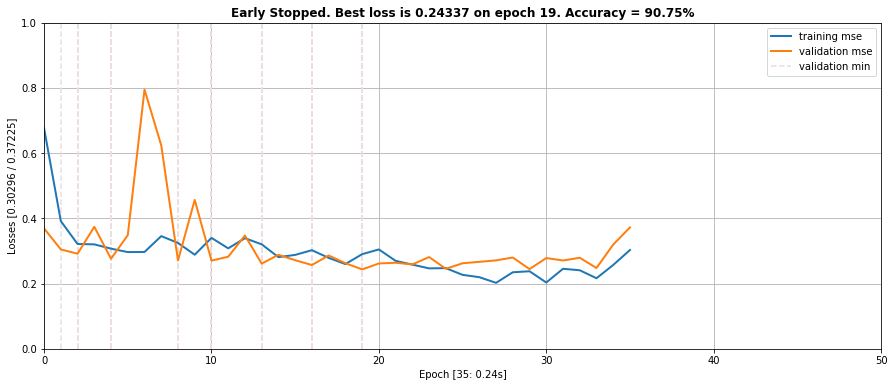

In [9]:
fit_params = {
    'opt':             SGD(lr=0.01, momentum=0.9, nesterov=True), 
    'nepochs':         50, 
    'patience':        15,
    'ploss':           1.0,
    'reset':           True,
}

train_network(model, model_name, train_features, train_labels, valid_features, valid_labels, **fit_params);

## Avaliação

In [10]:
test_network(model_name, valid_features, valid_labels)

Model from epoch 19
[INFO] evaluating in the test data set ...
800/800 [==============================] - 0s     

[INFO] accuracy on the test data set: 90.75% [0.24337]


## Atividade

1. Criar a rede VGG16 com pesos vencedores da Imagenet concatena com a rede Densa treinada neste notebook. Fazer a avalição desta rede com os dados de validação.


## Aprendizados com este notebook

1. O uso de uma rede pré-treinada com pesos utilizados em competições, serve para a extração eficiente de atributos das imagens de um modo geral. 
2. Os features gerados pela rede VGG16 podem ser utilizados para classificação utilizando qualquer classificador. Neste caso utilizamos um classificador por rede neural densa. Desta forma, poderemos posteriormente treinar a rede toda. Isso será visto no próximo notebook.
